In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
draft_data = pd.read_excel("DraftData.xlsx")
combine_data = pd.read_csv("2024combine.csv")
draft_data.head(), combine_data.head()

print(len(draft_data))
print(len(combine_data))

702
3751


In [3]:
combine_selected = combine_data[[
    "Player", "Ht", "Wt", "40yd", "Vertical", "Bench", "Broad Jump", "3Cone", "Shuttle"
]]

# Merge draft data with combine data on player name
merged_data = pd.merge(draft_data, combine_selected, on="Player", how="left")
merged_data.head()
merged_data.to_csv("NFLDraft.csv", index=False)
print(len(merged_data))

710


In [4]:
position_data = merged_data[
    [
        "Draft_Year", "Player", "Pos", "wAV", "DrAV", "G", "College_Univ", "Prospect_Grade",
        "Ht", "Wt", "40yd", "Vertical", "Bench", "Broad Jump", "3Cone", "Shuttle"
    ]
]

position_grouped = position_data.sort_values(by=["Pos", "Draft_Year"])
position_grouped.head()



,Draft_Year,Player,Pos,wAV,DrAV,G,College_Univ,Prospect_Grade,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
84,2015,Cameron Erving,C,28.0,6.0,98.0,Florida St.,6.2,6-5,313.0,5.15,30.5,30.0,112.0,7.48,4.63
126,2015,Ali Marpet,C,43.0,43.0,101.0,Hobart,5.9,6-4,307.0,4.98,30.5,30.0,108.0,7.33,4.47
147,2016,Ryan Kelly,C,54.0,54.0,121.0,Alabama,6.3,6-4,311.0,5.03,30.0,26.0,103.0,7.58,4.59
251,2017,Ethan Pocic,C,30.0,19.0,101.0,LSU,6.2,6-6,310.0,5.15,27.0,26.0,107.0,7.89,4.81
278,2018,Frank Ragnow,C,51.0,51.0,96.0,Arkansas,6.2,6-5,312.0,NaN,NaN,26.0,NaN,NaN,NaN


In [5]:
position_datasets = {
    position: df for position, df in position_grouped.groupby("Pos")
}

position_datasets["WR"]
len(position_datasets['QB'])

48

In [6]:
folder_path = "/Users/vhalaharivi/Desktop/cfb-data-webscraping-main/receiving"
receiver_stats = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        # Ensure "Career" row exists
        career_row = df[df['Season'] == 'Career']
        if not career_row.empty:
            # Extract only the relevant columns
            stats = career_row[['Player', 'G', 'Rec', 'Yds', 'Y/R', 'TD', 'Y/G', 'Att']]
            receiver_stats.append(stats)



# Combine all the individual stats into a single dataframe
all_receivers_df = pd.concat(receiver_stats, ignore_index=True)

# Optional: convert numeric columns to proper types (in case they are strings)
numeric_cols = ['G', 'Rec', 'Yds', 'Y/R', 'TD', 'Y/G', 'Att']
all_receivers_df[numeric_cols] = all_receivers_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

for pos in ['WR', 'TE']:
    if pos in position_datasets:
        position_datasets[pos] = position_datasets[pos].merge(
            all_receivers_df, on="Player", how="left", suffixes=('', '_college')
        )

position_datasets['TE'].to_csv("TightEnds.csv", index = False)
position_datasets['WR'].to_csv("WideReceivers.csv", index = False)


In [7]:
qb_folder_path = "/Users/vhalaharivi/Desktop/cfb-data-webscraping-main/passing"

qb_cols_needed = ['G', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'TD%', 'Int', 'Int%', 'Rate']

qb_stats = []

for filename in os.listdir(qb_folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(qb_folder_path, filename)
        df = pd.read_csv(file_path)

        # Get the 'Career' row only
        career_row = df[df['Season'] == 'Career']

        if not career_row.empty:
            # Try to get player name from file OR from column
            try:
                player_name = career_row['Player'].values[0]
            except KeyError:
                # Fallback: infer player name from filename
                base_name = os.path.basename(filename)
                player_name = base_name.replace("player_", "").split(".csv")[0]
                player_name = "_".join(player_name.split("_")[1:]).replace("_", " ").strip()

            # Prepare a dict with player name and stats
            stat_row = career_row[qb_cols_needed].copy()
            stat_row.insert(0, 'Player', player_name)
            qb_stats.append(stat_row)

# Combine into one dataframe
all_qbs_df = pd.concat(qb_stats, ignore_index=True)

# Convert numeric columns
numeric_cols = [col for col in all_qbs_df.columns if col != "Player"]
all_qbs_df[numeric_cols] = all_qbs_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Merge back into the QB dataset
position_datasets["QB"] = position_datasets["QB"].merge(
    all_qbs_df, on="Player", how="left", suffixes=('', '_college')
)

# Preview the result
position_datasets["QB"].to_csv("Quarterbacks.csv", index = False)



In [14]:
rb_folder_path = "/Users/vhalaharivi/Desktop/cfb-data-webscraping-main/rushing"

rb_columns = ['G', 'Att', 'Yds', 'Y/A', 'TD', 'Y/G', 'Rec', 'Yds.1', 'Y/R', 'TD.1']
rb_stats = []

for filename in os.listdir(rb_folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(rb_folder_path, filename)
        df = pd.read_csv(file_path)
        career_row = df[df['Season'] == 'Career']
        if not career_row.empty:
            try:
                player_name = career_row['Player'].values[0]
            except KeyError:
                base_name = os.path.basename(filename)
                player_name = base_name.replace("player_", "").split(".csv")[0]
                player_name = "_".join(player_name.split("_")[1:]).replace("_", " ").strip()

            stat_row = career_row[rb_columns].copy()
            stat_row.insert(0, 'Player', player_name)
            rb_stats.append(stat_row)

all_rbs_df = pd.concat(rb_stats, ignore_index=True)

numeric_cols = [col for col in all_rbs_df.columns if col != "Player"]
all_rbs_df[numeric_cols] = all_rbs_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

position_datasets["RB"] = position_datasets["RB"].merge(
    all_rbs_df,
    on="Player",
    how="left",  
    suffixes=('', '_college')
)
position_datasets["RB"].to_csv("Runningbacks.csv", index = False)

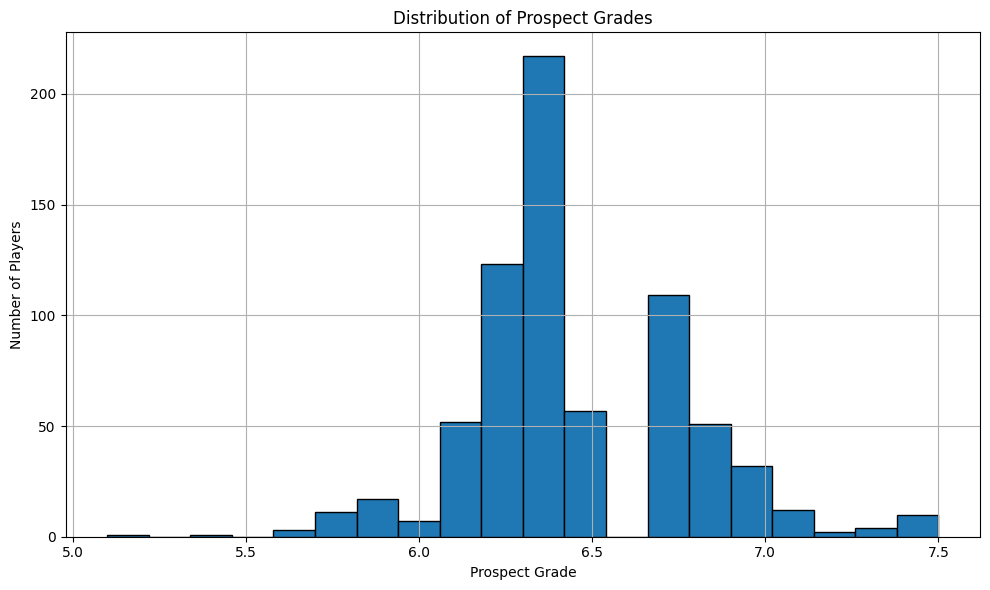

In [10]:
df = pd.read_csv("NFLDraft.csv")

# Plot histogram of Prospect_Grade
plt.figure(figsize=(10, 6))
plt.hist(df['Prospect_Grade'].dropna(), bins=20, edgecolor='black')
plt.title("Distribution of Prospect Grades")
plt.xlabel("Prospect Grade")
plt.ylabel("Number of Players")
plt.grid(True)
plt.tight_layout()
plt.show()

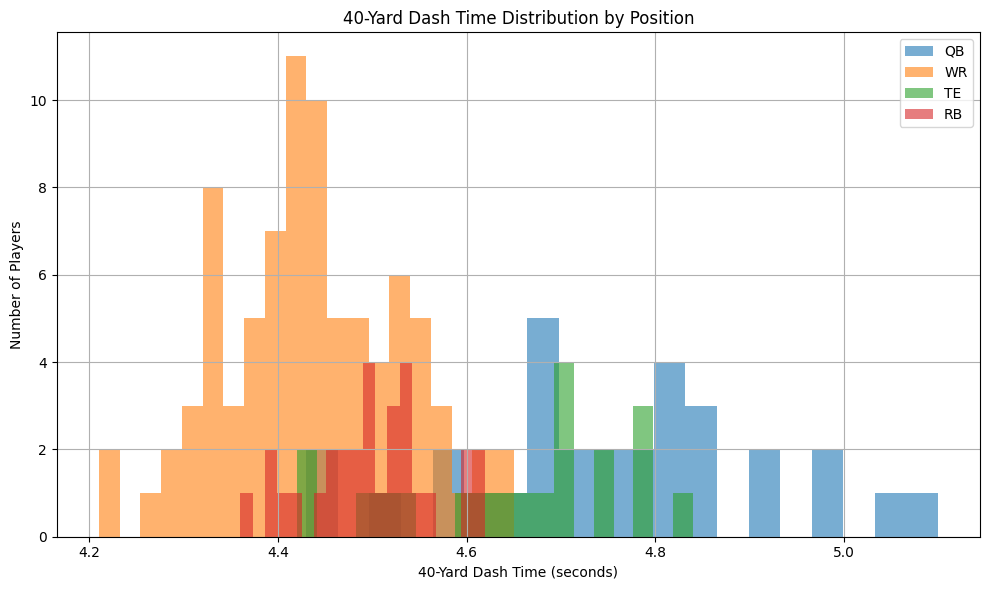

In [15]:
qbs = pd.read_csv("Quarterbacks.csv")
wrs = pd.read_csv("WideReceivers.csv")
tes = pd.read_csv("TightEnds.csv")
rbs = pd.read_csv("Runningbacks.csv")

qbs["Position"] = "QB"
wrs["Position"] = "WR"
tes["Position"] = "TE"
rbs["Position"] = "RB"


combined = pd.concat([qbs, wrs, tes, rbs], ignore_index=True)

# Drop rows with missing 40yd times
combined = combined.dropna(subset=["40yd"])

# Convert 40yd column to numeric (if needed)
combined["40yd"] = pd.to_numeric(combined["40yd"], errors="coerce")

# Plot histogram by position
plt.figure(figsize=(10, 6))
for pos in combined["Position"].unique():
    subset = combined[combined["Position"] == pos]
    plt.hist(subset["40yd"], bins=20, alpha=0.6, label=pos)

plt.title("40-Yard Dash Time Distribution by Position")
plt.xlabel("40-Yard Dash Time (seconds)")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/kr/91p59jqd5k7fczhhgjwhc7m80000gn/T/ipykernel_1057/741481797.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined, x="Position", y="Prospect_Grade", palette=palette)


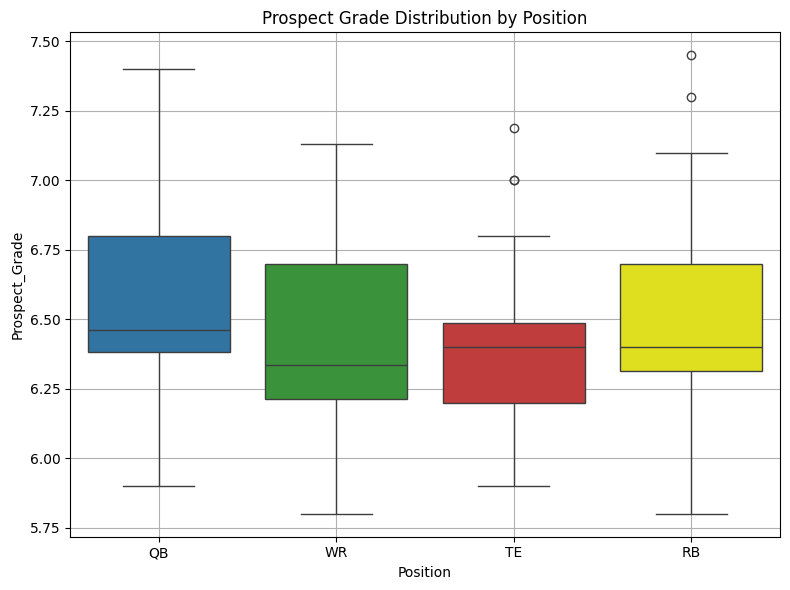

In [18]:
combined = pd.concat([qbs, wrs, tes, rbs], ignore_index=True)

palette = {
    "QB": "#1f77b4",   # Blue
    "WR": "#2ca02c",   # Green
    "TE": "#d62728" ,   # Red
    "RB": "#ffff00"
}
# Convert 40yd and Prospect_Grade to numeric (handle errors)
combined["40yd"] = pd.to_numeric(combined["40yd"], errors="coerce")
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined, x="Position", y="Prospect_Grade", palette=palette)
plt.title("Prospect Grade Distribution by Position")
plt.grid(True)
plt.tight_layout()
plt.show()